# Data wrangling


## Gathering

- Download the tweet image predictions. 

In [1]:
import requests
import pandas as pd
import numpy as np
import tweepy
import matplotlib.pyplot as plt
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import os
import re
import seaborn as sns
%matplotlib inline

In [2]:
url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
file_name = url.split('/')[-1]
if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(response.content)

In [3]:
df_image_predictions = pd.read_csv(file_name, sep='\t')
# df_image_predictions.head()

- Load archive dataset

In [4]:
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
# df_archive.head()

get data from twitter api

In [6]:
consumer_key = "HIDDEN"
consumer_secret_key = "HIDDEN"
access_token = "HIDDEN"
access_secret = "HIDDEN"

In [8]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret_key)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [13]:
exp_tweet = api.get_status(df_archive.tweet_id[1000], tweet_mode = 'extended')
content = exp_tweet._json
print(content.keys())

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])


In [22]:
errors = []
if not os.path.isfile('tweet_json.txt'):
    with open('tweet_json.txt', 'w') as file:
        for tweet_id in df_archive['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True,
                                        tweet_mode = 'extended')
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)

Error on tweet id 888202515573088257;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 873697596434513921;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 872668790621863937;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 872261713294495745;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 869988702071779329;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 866816280283807744;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 861769973181624320;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 856602993587888130;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 851953902622658560;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 845459076796616705;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 844704788403

Rate limit reached. Sleeping for: 289


Error on tweet id 754011816964026368;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 680055455951884288;[{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 213


In [23]:
print(errors)

[888202515573088257, 873697596434513921, 872668790621863937, 872261713294495745, 869988702071779329, 866816280283807744, 861769973181624320, 856602993587888130, 851953902622658560, 845459076796616705, 844704788403113984, 842892208864923648, 837366284874571778, 837012587749474308, 829374341691346946, 827228250799742977, 812747805718642688, 802247111496568832, 779123168116150273, 775096608509886464, 771004394259247104, 770743923962707968, 759566828574212096, 754011816964026368, 680055455951884288]


In [5]:
df_list = []
for line in open('tweet_json.txt'):
    tweet = json.loads(line)
    tweet_id = tweet['id']
    retweet_count = tweet['retweet_count']
    fav_count = tweet['favorite_count']
    df_list.append({'tweet_id':tweet_id,
                   'retweet_count':retweet_count,
                   'favorite_count':fav_count})
df_api = pd.DataFrame(df_list)

In [26]:
print(tweet.keys())

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])


# Assessing Data

## Quality:
- archive data:
    - rows in (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`) that not NaN should be deleted
    - missing values in column `expanded_urls`
    - Columns (`doggo`, `floofer`, `pupper`, `puppo`): None instead of NaN for missing values
    - Column `name` has inconsistent values(none, a, ...), not extracted from tweet text.
    - Column `timestamp`: datatype object instead of date time
    - Columns `rating_numerator` and `rating dominator` have inaccurate values
- df_image_predictions
    - `p1`, `p1_conf`, `p1_dog`, `p2`, `p2_conf`, `p2_dog`, `p3`, `p3_conf`, `p3_dog` columns names nondescriptive
- There is difference between number of tweets in archive dataset, api dataset and image prediction dataset, Tweets that hasn't image sould be deleted

## Tidiness
- archive data: 
    - Columns(`doggo`, `floofer`, `pupper`, `puppo`) are values not variables name
- archive dataset and image prediction dataset and api dataset should be joined

In [7]:
df_archive.shape

(2356, 17)

In [8]:
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [9]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
print(df_archive['text'])
print(df_archive['name'])

0       This is Phineas. He's a mystical boy. Only eve...
1       This is Tilly. She's just checking pup on you....
2       This is Archie. He is a rare Norwegian Pouncin...
3       This is Darla. She commenced a snooze mid meal...
4       This is Franklin. He would like you to stop ca...
                              ...                        
2351    Here we have a 1949 1st generation vulpix. Enj...
2352    This is a purebred Piers Morgan. Loves to Netf...
2353    Here is a very happy pup. Big fan of well-main...
2354    This is a western brown Mitsubishi terrier. Up...
2355    Here we have a Japanese Irish Setter. Lost eye...
Name: text, Length: 2356, dtype: object
0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351        None
2352           a
2353           a
2354           a
2355        None
Name: name, Length: 2356, dtype: object


In [11]:
df_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [12]:
df_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [13]:
df_image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1779,828409743546925057,https://pbs.twimg.com/media/C38aQYgXAAMY2Wh.jpg,1,teddy,0.908457,False,toy_poodle,0.018040,True,standard_poodle,0.012667,True
1408,770293558247038976,https://pbs.twimg.com/media/CrCh5RgW8AAXW4U.jpg,1,Italian_greyhound,0.931668,True,Mexican_hairless,0.038896,True,whippet,0.013151,True
1683,813944609378369540,https://pbs.twimg.com/media/Cveg1-NXgAASaaT.jpg,1,Labrador_retriever,0.427742,True,Great_Dane,0.190503,True,curly-coated_retriever,0.146427,True
505,675891555769696257,https://pbs.twimg.com/media/CWE_x33UwAEE3no.jpg,1,Italian_greyhound,0.305637,True,whippet,0.232057,True,Great_Dane,0.117806,True
86,667517642048163840,https://pbs.twimg.com/media/CUN_wiBUkAAakT0.jpg,1,Italian_greyhound,0.125176,True,standard_poodle,0.084572,True,cocker_spaniel,0.081347,True
945,704480331685040129,https://pbs.twimg.com/media/CcbRIAgXIAQaKHQ.jpg,1,Samoyed,0.979206,True,Pomeranian,0.007185,True,Arctic_fox,0.006438,False
1481,780931614150983680,https://pbs.twimg.com/media/CtZtJxAXEAAyPGd.jpg,1,padlock,0.731564,False,necklace,0.065462,False,chain,0.036469,False
1026,710833117892898816,https://pbs.twimg.com/media/Cd1i8qvUkAE-Jlr.jpg,1,Pembroke,0.803742,True,Cardigan,0.189712,True,German_shepherd,0.001746,True
1603,800141422401830912,https://pbs.twimg.com/media/CxqsX-8XUAAEvjD.jpg,3,golden_retriever,0.938048,True,kuvasz,0.025119,True,Labrador_retriever,0.022977,True
1090,719339463458033665,https://pbs.twimg.com/media/Cfuba6NW4AIeMHk.jpg,1,golden_retriever,0.765778,True,borzoi,0.071148,True,Leonberg,0.070371,True


In [14]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
df_image_predictions.shape

(2075, 12)

In [16]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [17]:
df_api.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7431,35237
1,892177421306343426,5526,30501
2,891815181378084864,3647,22935
3,891689557279858688,7609,38520
4,891327558926688256,8192,36794


# Cleaning Data

## Quality

In [79]:
df_archive_clean = df_archive.copy()

In [80]:
df_api_clean = df_api.copy()

In [81]:
df_image_predictions_clean = df_image_predictions.copy()

### Define
- Drop rwos that have values in columns(`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`) in archive dataset
- Drop rows that have NaN in `expanded_urls` column in archive dataset

### Code

In [82]:
df_archive_clean = df_archive_clean[df_archive_clean['in_reply_to_status_id'].isnull()]
df_archive_clean = df_archive_clean[df_archive_clean['in_reply_to_user_id'].isnull()]
df_archive_clean = df_archive_clean[df_archive_clean['retweeted_status_id'].isnull()]
df_archive_clean = df_archive_clean[df_archive_clean['retweeted_status_user_id'].isnull()]
df_archive_clean = df_archive_clean[df_archive_clean['retweeted_status_timestamp'].isnull()]

In [83]:
df_archive_clean.dropna(subset=['expanded_urls'],inplace=True)

In [84]:
df_archive_clean.drop(columns=['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                              'retweeted_status_user_id','retweeted_status_timestamp'],inplace=True)

### Test

In [85]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2094 non-null   int64 
 1   timestamp           2094 non-null   object
 2   source              2094 non-null   object
 3   text                2094 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2094 non-null   int64 
 6   rating_denominator  2094 non-null   int64 
 7   name                2094 non-null   object
 8   doggo               2094 non-null   object
 9   floofer             2094 non-null   object
 10  pupper              2094 non-null   object
 11  puppo               2094 non-null   object
dtypes: int64(3), object(9)
memory usage: 212.7+ KB


### Define
- Replace "None" with NaN in `doggo`, `floofer`, `pupper`, `puppo` columns

### Code
solved with tidiness issue

In [86]:
# df_archive_clean.iloc[:,-4:] = df_archive_clean.iloc[:,-4:].replace('None',np.nan)

### Test

In [14]:
# df_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN


### Define
- Change `timestamp` datatype to datetime

### Code

In [87]:
df_archive_clean['timestamp'] = pd.to_datetime(df_archive_clean['timestamp'])

### Test

In [88]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   int64              
 6   rating_denominator  2094 non-null   int64              
 7   name                2094 non-null   object             
 8   doggo               2094 non-null   object             
 9   floofer             2094 non-null   object             
 10  pupper              2094 non-null   object             
 11  puppo               2094 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

### Define
- For `rating_dominator` get the values above 10 and check their text to extract the accurate value


### Code

In [89]:
df_archive_tmp = df_archive_clean[df_archive_clean['rating_denominator']>10]
df_archive_tmp

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,2017-01-15 17:52:40+00:00,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
902,758467244762497024,2016-07-28 01:00:57+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,2016-05-13 16:15:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,2016-04-21 02:25:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,2016-04-03 01:36:11+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,2016-03-27 01:29:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,2016-03-18 02:46:49+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
1274,709198395643068416,2016-03-14 02:04:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,45,50,None,None,None,None,None
1351,704054845121142784,2016-02-28 21:25:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,https://twitter.com/dog_rates/status/704054845...,60,50,a,None,None,None,None


In [90]:
for i in range(len(df_archive_tmp['text'])):
    print(df_archive_tmp.iloc[i]['text'])  
    print(df_archive_tmp.iloc[i]['rating_numerator'], df_archive_tmp.iloc[i]['rating_denominator'],'\n','\n')

The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
84 70 
 

Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
165 150 
 

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
9 11 
 

Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
204 170 
 

Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
4 20 
 

This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
50 50 
 

Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
99 90 
 

Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
80 80 
 

From left to right:
Cletus, Jerome, Alejandro, Burp, &amp; Titson
None know where camera i

Get the dogs count from tweets that have image with more than dog

In [91]:
dogs_count = df_archive_tmp[df_archive_clean['rating_numerator']>40]['rating_denominator'] /10
dogs_count

/home/nourhan/anaconda3/envs/fwd_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


433      7.0
902     15.0
1120    17.0
1202     5.0
1228     9.0
1254     8.0
1274     5.0
1351     5.0
1433     4.0
1635    11.0
1779    12.0
1843     8.0
Name: rating_denominator, dtype: float64

In [92]:
df_archive_clean.loc[df_archive_clean.rating_numerator > 40, ['rating_numerator', 'rating_denominator']] = [df_archive_clean.rating_numerator[df_archive_clean.rating_numerator > 40]/dogs_count , 10]


/home/nourhan/anaconda3/envs/fwd_env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### for the first row in the cell below, this dog has no rate, drop this row
#### for the rest of rows, extract the right rate from the text

In [93]:
df_archive_tmp = df_archive_clean[df_archive_clean['rating_denominator']!=10]
for i in range(len(df_archive_tmp['text'])):
    print(df_archive_tmp.iloc[i]['text'])  
    print(df_archive_tmp.iloc[i]['rating_numerator'], df_archive_tmp.iloc[i]['rating_denominator'],'\n','\n')

Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
24.0 7 
 

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
9.0 11 
 

Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
4.0 20 
 

This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
7.0 11 
 

This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
1.0 2 
 



In [94]:
df_archive_clean = df_archive_clean[df_archive_clean['rating_numerator'] != 24]
df_archive_clean[df_archive_clean['rating_numerator'] == 24]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [95]:
d = df_archive_clean[df_archive_clean['rating_denominator']!=10].text.str.extractall('(\d+\.?\d?\d?)\/\d{1,3}').astype('float')
d

0
     match      
1068 0       9.0
     1      14.0
1165 0       4.0
     1      13.0
1662 0       7.0
     1      10.0
2335 0       1.0
     1       9.0

In [96]:
mset = set(d.index.get_level_values(0))
for val in mset:
    df_archive_clean.loc[[val],['rating_numerator','rating_denominator']] = [d.loc[val].iloc[1],10]

/home/nourhan/anaconda3/envs/fwd_env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Test

In [97]:
df_archive_clean[df_archive_clean['rating_denominator']!=10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [98]:
df_archive_clean['rating_numerator'].value_counts()

12.0    489
10.0    437
11.0    418
13.0    288
9.0     154
8.0      98
7.0      51
14.0     39
5.0      34
6.0      32
3.0      19
4.0      15
2.0       9
1.0       4
0.0       1
26.0      1
27.0      1
Name: rating_numerator, dtype: int64

In [99]:
df_archive_clean.shape

(2093, 12)

### Define
Replace ('None', 'a', 'an, ..) in `name` column to their right name or NaN

### Code

In [101]:
df_archive_clean['name'].value_counts(dropna=False)

None       600
a           55
Charlie     11
Lucy        11
Cooper      10
          ... 
Tanner       1
Pepper       1
Dobby        1
Lenox        1
Duddles      1
Name: name, Length: 955, dtype: int64

In [102]:
mask = df_archive_clean.name.str.islower() 
column_name = 'name' 
df_archive_clean.loc[mask, column_name] = np.nan

In [103]:
df_archive_clean['name'] = df_archive_clean['name'].replace('None', np.nan)

### Test

In [104]:
df_archive_clean.name.value_counts(dropna = False)

NaN        704
Lucy        11
Charlie     11
Oliver      10
Cooper      10
          ... 
Carly        1
Mona         1
Ivar         1
Derby        1
Bubba        1
Name: name, Length: 930, dtype: int64

### Define
- Change `p1`, `p1_conf`, `p1_dog`, `p2`, `p2_conf`, `p2_dog`, `p3`, `p3_conf`, `p3_dog` columns names in image prediction dataset to 'prediction_1', 'confidence_1', 'dog_1', 'prediction_2', 'confidence_2', 'dog_2', 'prediction_3', 'confidence_3', 'dog_3'

### Code

In [105]:
df_image_predictions_clean.rename(columns={'p1':'prediction_1', 'p2':'prediction_2', 'p3':'prediction_3',
                                          'p1_conf':'confidence_1', 'p2_conf':'confidence_2', 'p3_conf':'confidence_3',
                                          'p1_dog':'dog_1', 'p2_dog':'dog_2', 'p3_dog':'dog_3'}, inplace=True)

### Test

In [106]:
df_image_predictions_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'prediction_1', 'confidence_1',
       'dog_1', 'prediction_2', 'confidence_2', 'dog_2', 'prediction_3',
       'confidence_3', 'dog_3'],
      dtype='object')

### Define
Remove rows with no image from archive dataset and api dataset and remove rows that are retweets or replies from image prediction data

### Code

In [107]:
tweets_img = list(df_image_predictions_clean['tweet_id'].unique())
df_archive_clean = df_archive_clean[df_archive_clean['tweet_id'].isin(tweets_img)]
df_api_clean = df_api_clean[df_api_clean['tweet_id'].isin(tweets_img)]

In [108]:
df_image_predictions_clean = df_image_predictions_clean[df_image_predictions_clean['tweet_id'].isin(list(df_archive_clean['tweet_id']))]

### Test

In [126]:
df_archive_clean.shape

(1970, 11)

In [127]:
df_api_clean.shape

(2059, 3)

In [128]:
df_image_predictions_clean.shape

(1970, 12)

## Tidiness


### Define
Compress (doggo, floofer, pupper, puppo) columns under one column 'dog_category'


### Code

In [112]:
df_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

In [113]:
df_archive_clean.iloc[:, -4:] = df_archive_clean.iloc[:, -4:].replace('None',"")

In [114]:
df_archive_clean['dog_stage'] = df_archive_clean['doggo'] + df_archive_clean['floofer'] + df_archive_clean['pupper'] + df_archive_clean['puppo']
df_archive_clean.dog_stage.value_counts()


                1667
pupper           201
doggo             63
puppo             22
doggopupper        8
floofer            7
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64

In [115]:
df_archive_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace = True)

In [116]:
df_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_stage'],
      dtype='object')

In [117]:
df_archive_clean.loc[df_archive_clean['dog_stage'] == 'doggopupper', ['dog_stage']] = 'doggo_pupper'

In [118]:
df_archive_clean.loc[df_archive_clean['dog_stage'] == 'doggofloofer', ['dog_stage']] = 'doggo_floofer'
df_archive_clean.loc[df_archive_clean['dog_stage'] == 'doggopuppo', ['dog_stage']] = 'doggo_puppo'

In [119]:
df_archive_clean['dog_stage'] = df_archive_clean['dog_stage'].replace("", np.nan)

### Test

In [120]:
df_archive_clean['dog_stage'].value_counts()

pupper           201
doggo             63
puppo             22
doggo_pupper       8
floofer            7
doggo_floofer      1
doggo_puppo        1
Name: dog_stage, dtype: int64

In [121]:
df_archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,NaN
...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5.0,10,NaN,NaN
2352,666044226329800704,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6.0,10,NaN,NaN
2353,666033412701032449,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9.0,10,NaN,NaN
2354,666029285002620928,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7.0,10,NaN,NaN


### Define
- merge archive dataset and api dataset and image predictions dataset

### Code

In [122]:
df_archive_clean = pd.merge(df_archive_clean, df_api_clean, on=['tweet_id'], how='left')
Twitter_archive_master = pd.merge(df_archive_clean, df_image_predictions_clean, on=['tweet_id'], how='left')

### Test

In [123]:
Twitter_archive_master.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_stage',
       'retweet_count', 'favorite_count', 'jpg_url', 'img_num', 'prediction_1',
       'confidence_1', 'dog_1', 'prediction_2', 'confidence_2', 'dog_2',
       'prediction_3', 'confidence_3', 'dog_3'],
      dtype='object')

In [124]:
Twitter_archive_master.shape

(1970, 22)

# Store dataset

In [125]:
Twitter_archive_master.to_csv('Twitter_archive_master.csv', index=False)


# Analyze & visualization

In [64]:
Twitter_archive_master = pd.read_csv('Twitter_archive_master.csv')

In [65]:
Twitter_archive_master.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,jpg_url,img_num,prediction_level,prediction,confidence,dog
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,NaN,7431.0,35237.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,1,orange,0.097049,False
1,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,NaN,7431.0,35237.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,2,bagel,0.085851,False
2,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,NaN,7431.0,35237.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,3,banana,0.076110,False
3,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,NaN,5526.0,30501.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,1,Chihuahua,0.323581,True
4,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,NaN,5526.0,30501.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,2,Pekinese,0.090647,True


In [66]:
Twitter_archive_master.groupby('dog_stage')['favorite_count'].sum()

dog_stage
doggo            3419316.0
doggo_floofer      46425.0
doggo_pupper      318672.0
doggo_puppo       130344.0
floofer           246267.0
pupper           3941109.0
puppo            1346430.0
Name: favorite_count, dtype: float64

In [67]:
Twitter_archive_master.groupby('dog_stage')['rating_numerator'].mean()

dog_stage
doggo            11.888889
doggo_floofer    11.000000
doggo_pupper     11.000000
doggo_puppo      13.000000
floofer          12.000000
pupper           10.716418
puppo            12.000000
Name: rating_numerator, dtype: float64

In [68]:
Twitter_archive_master['dog_stage'].value_counts()

pupper           603
doggo            189
puppo             66
doggo_pupper      24
floofer           21
doggo_floofer      3
doggo_puppo        3
Name: dog_stage, dtype: int64

In [69]:
Twitter_archive_master.groupby('dog_stage')['favorite_count'].mean()

dog_stage
doggo            18383.419355
doggo_floofer    15475.000000
doggo_pupper     13278.000000
doggo_puppo      43448.000000
floofer          11727.000000
pupper            6535.835821
puppo            20400.454545
Name: favorite_count, dtype: float64

In [70]:
Twitter_archive_master.groupby('dog_stage')['retweet_count'].mean()

dog_stage
doggo             6309.048387
doggo_floofer     2949.000000
doggo_pupper      3929.250000
doggo_puppo      16861.000000
floofer           4196.142857
pupper            2035.820896
puppo             5620.363636
Name: retweet_count, dtype: float64

In [71]:
avg_favorite = Twitter_archive_master.groupby('dog_stage')['favorite_count'].mean()
avg_retweet = Twitter_archive_master.groupby('dog_stage')['retweet_count'].mean()


In [72]:
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(10,6)})

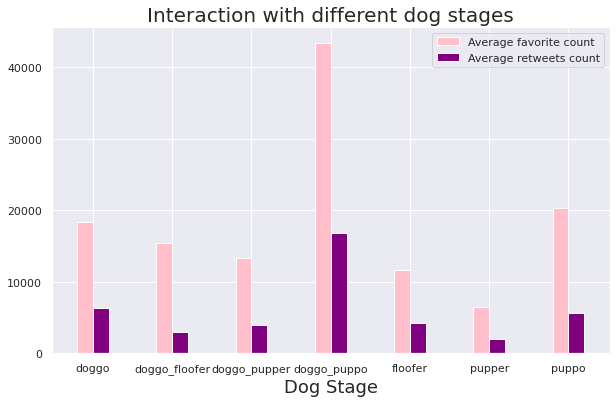

In [73]:
ind = np.arange(len(avg_favorite))
width=0.20
red_bars = plt.bar(ind, avg_favorite, width, color='pink', label='Average favorite count')
blue_bars = plt.bar(ind + width, avg_retweet, width, color='purple', label='Average retweets count')

plt.xlabel('Dog Stage', size=18)
plt.title('Interaction with different dog stages', size=20)
locations = ind + width / 2 
labels = Twitter_archive_master.groupby('dog_stage')['favorite_count'].mean().index.tolist()
plt.xticks(locations, labels)

plt.legend()

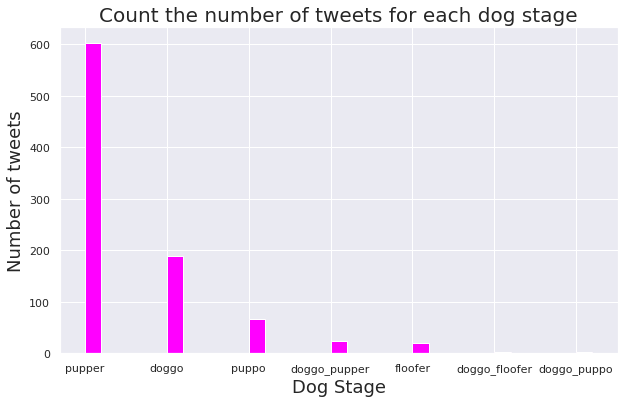

In [74]:
dog_count = Twitter_archive_master['dog_stage'].value_counts()
ind = np.arange(len(dog_count))

bars = plt.bar(ind + width, dog_count, width, color='magenta')

plt.xlabel('Dog Stage', size=18)
plt.ylabel('Number of tweets', size=18)
plt.title('Count the number of tweets for each dog stage', size=20)
locations = ind + width / 2 
labels = Twitter_archive_master['dog_stage'].value_counts().index.tolist() 
plt.xticks(locations, labels);
# plt.legend()

In [75]:
Twitter_archive_master['timestamp'] = pd.to_datetime(Twitter_archive_master['timestamp'])

In [76]:
Twitter_archive_master['year'] = Twitter_archive_master['timestamp'].dt.year

In [77]:
Twitter_archive_master['month'] = Twitter_archive_master['timestamp'].dt.month

In [78]:
Twitter_archive_master['month'] = pd.to_datetime(Twitter_archive_master['month'], format='%m').dt.month_name()


In [79]:
Twitter_archive_master['month'] = Twitter_archive_master['month'].str.slice(stop=3)

In [80]:
Twitter_archive_master['month'].value_counts()

Dec    1239
Nov    1041
Jan     696
Feb     516
Mar     495
Jul     411
Jun     369
May     294
Apr     282
Oct     195
Sep     189
Aug     183
Name: month, dtype: int64

In [81]:
months = Twitter_archive_master.groupby(['year','month'])['favorite_count'].mean().index.tolist()
months

[(2015, 'Dec'),
 (2015, 'Nov'),
 (2016, 'Apr'),
 (2016, 'Aug'),
 (2016, 'Dec'),
 (2016, 'Feb'),
 (2016, 'Jan'),
 (2016, 'Jul'),
 (2016, 'Jun'),
 (2016, 'Mar'),
 (2016, 'May'),
 (2016, 'Nov'),
 (2016, 'Oct'),
 (2016, 'Sep'),
 (2017, 'Apr'),
 (2017, 'Aug'),
 (2017, 'Feb'),
 (2017, 'Jan'),
 (2017, 'Jul'),
 (2017, 'Jun'),
 (2017, 'Mar'),
 (2017, 'May')]

In [82]:
values =Twitter_archive_master.groupby(['year','month'])['favorite_count'].mean()
values

year  month
2015  Dec       3154.086351
      Nov       1145.389831
2016  Apr       4262.981481
      Aug       9247.254237
      Dec      15147.037736
      Feb       3928.361111
      Jan       3603.921687
      Jul       6356.528736
      Jun       9650.012658
      Mar       4113.576271
      May       5681.928571
      Nov      13223.557692
      Oct      11799.230769
      Sep      10094.548387
2017  Apr      21128.775000
      Aug      32869.000000
      Feb      16603.523810
      Jan      17857.484848
      Jul      29094.693878
      Jun      26249.534884
      Mar      17901.555556
      May      27287.119048
Name: favorite_count, dtype: float64

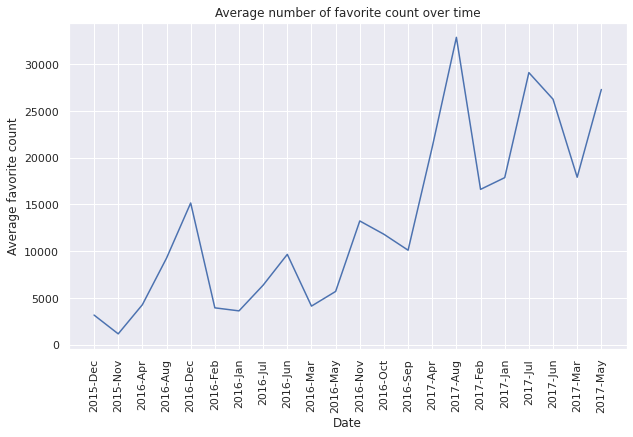

In [83]:
ax = values.plot(xlabel='Date', ylabel='Average favorite count', title= 'Average number of favorite count over time')
ax.set_xticks(range(len(values)))
ax.set_xticklabels(["%s-%03s" % item for item in values.index.tolist()], rotation=90);

<AxesSubplot:xlabel='dog_stage', ylabel='rating numerator'>

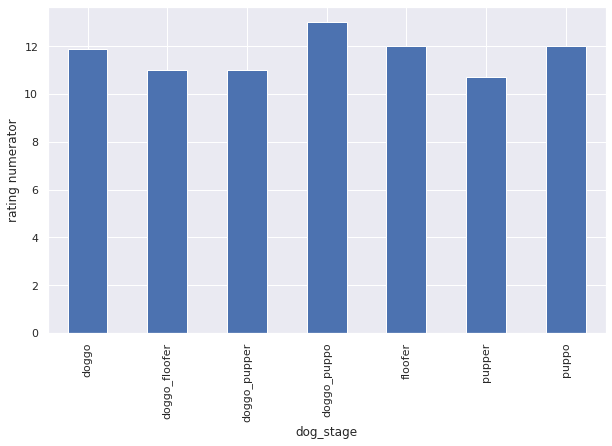

In [84]:
Twitter_archive_master.groupby('dog_stage')['rating_numerator'].mean().plot(kind='bar', ylabel='rating numerator')